In [87]:
import pandas as pd
import numpy as np

In [103]:
df =pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [105]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [107]:
df.isna().sum(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


(lead_source                 128
 industry                    134
 number_of_courses_viewed      0
 annual_income               181
 employment_status           100
 location                     63
 interaction_count             0
 lead_score                    0
 converted                     0
 dtype: int64,
 None)

In [109]:
num_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']
cat_cols = ['lead_source', 'industry', 'employment_status', 'location']
for col in num_cols:
    df[num_cols] = df[num_cols].fillna(0.0)
for col in cat_cols:    
    df[cat_cols] = df[cat_cols].fillna('NA')

In [111]:
for col in ['lead_source', 'industry', 'annual_income', 'employment_status', 'location']:
    print(df[col].unique())

['paid_ads' 'social_media' 'events' 'referral' 'organic_search' 'NA']
['NA' 'retail' 'healthcare' 'education' 'manufacturing' 'technology'
 'other' 'finance']
[79450. 46992. 78796. ... 45688. 71016. 92855.]
['unemployed' 'employed' 'NA' 'self_employed' 'student']
['south_america' 'australia' 'europe' 'africa' 'middle_east' 'NA'
 'north_america' 'asia']


In [113]:
df['industry'].mode()

0    retail
Name: industry, dtype: object

<Axes: >

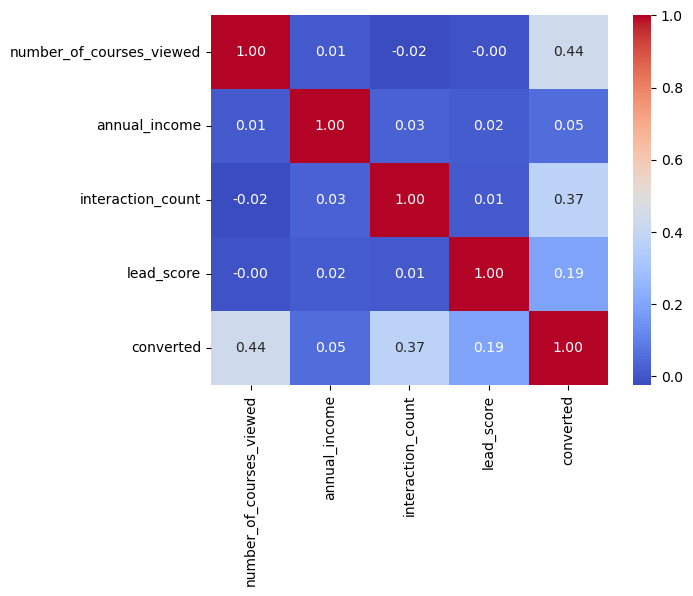

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

In [117]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=42)

In [119]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [121]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [123]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [125]:
df_full_train.isna().sum(), df_full_train['converted'].value_counts(normalize=True)

(lead_source                 0
 industry                    0
 number_of_courses_viewed    0
 annual_income               0
 employment_status           0
 location                    0
 interaction_count           0
 lead_score                  0
 converted                   0
 dtype: int64,
 converted
 1    0.607357
 0    0.392643
 Name: proportion, dtype: float64)

In [143]:
from sklearn.metrics import mutual_info_score
score = mutual_info_score(df_full_train['converted'], df_full_train['lead_source'])
round(score, 2)

0.03

In [145]:
score_2 = mutual_info_score(df_full_train['converted'], df_full_train['industry'])
round(score_2, 2)

0.01

In [147]:
score_3 = mutual_info_score(df_full_train['converted'], df_full_train['location'])
round(score_3, 2)

0.0

In [149]:
score_4 = mutual_info_score(df_full_train['converted'], df_full_train['employment_status'])
round(score_4, 2)

0.01

In [151]:
def mutual_info_converted_score(series):
    return mutual_info_score(series, df_full_train['converted'])

In [155]:
df_full_train[cat_cols].apply(mutual_info_converted_score).sort_values(ascending=False)

lead_source          0.025665
employment_status    0.013258
industry             0.011685
location             0.002253
dtype: float64

In [159]:
df_full_train[num_cols].corrwith(df_full_train['converted']).sort_values(ascending=False)

converted                   1.000000
number_of_courses_viewed    0.442068
interaction_count           0.378482
lead_score                  0.225641
annual_income               0.029612
dtype: float64

In [173]:
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_train[num_cols + cat_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)
val_dicts = df_val[num_cols + cat_cols].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [175]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict_proba(x_val)[:, 1]
y_pred_labels = (y_pred>= 0.5).astype(int)

In [181]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred_labels)
print(round(accuracy,2))

0.76


In [187]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=model, n_features_to_select=1)
rfe.fit(x_train, y_train) 
feature_names = dv.get_feature_names_out()
least_important_feature = feature_names[rfe.support_ == False][0]
print(f"leleast_important_feature: {least_important_feature}")

leleast_important_feature: annual_income


In [211]:
list(zip(feature_names, model.coef_[0].round(3)))


[('annual_income', -0.0),
 ('converted', 0.399),
 ('employment_status=NA', -0.009),
 ('employment_status=employed', 0.025),
 ('employment_status=self_employed', 0.007),
 ('employment_status=student', 0.016),
 ('employment_status=unemployed', -0.063),
 ('industry=NA', -0.015),
 ('industry=education', 0.036),
 ('industry=finance', -0.012),
 ('industry=healthcare', -0.005),
 ('industry=manufacturing', 0.001),
 ('industry=other', -0.003),
 ('industry=retail', -0.018),
 ('industry=technology', -0.009),
 ('interaction_count', 0.344),
 ('lead_score', 0.045),
 ('lead_source=NA', 0.017),
 ('lead_source=events', -0.006),
 ('lead_source=organic_search', -0.003),
 ('lead_source=paid_ads', -0.074),
 ('lead_source=referral', 0.058),
 ('lead_source=social_media', -0.017),
 ('location=NA', 0.004),
 ('location=africa', -0.005),
 ('location=asia', -0.006),
 ('location=australia', -0.0),
 ('location=europe', 0.01),
 ('location=middle_east', 0.007),
 ('location=north_america', -0.019),
 ('location=south_a

In [225]:
features_to_remove = ['industry', 'employment_status', 'lead_score']
accuracy_diff = {}
for feature in features_to_remove:
    removed_cols = [col for col in (num_cols + cat_cols) if col != feature]
    train_dicts = df_train[removed_cols].to_dict(orient='records')
    val_dicts = df_val[removed_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(train_dicts)
    x_val = dv.transform(val_dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)[:, 1]
    y_pred_labels = (y_pred >= 0.5).astype(int)
    acc = accuracy_score(y_val, y_pred_labels)
    diff = accuracy - acc
    accuracy_diff[feature] = diff
    print(f"Removed {feature}: accuracy = {acc}, difference = {diff}")

Removed industry: accuracy = 0.764505119453925, difference = -0.006825938566553003
Removed employment_status: accuracy = 0.764505119453925, difference = -0.006825938566553003
Removed lead_score: accuracy = 0.7610921501706485, difference = -0.0034129692832765013


In [227]:
train_dicts = df_train[num_cols + cat_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)
val_dicts = df_val[num_cols + cat_cols].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [235]:
c_values =[0.01, 0.1, 1, 10, 100]
accuracies = {}
for C in c_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)[:, 1]
    y_pred_labels = (y_pred >= 0.5).astype(int)
    acc= accuracy_score(y_val, y_pred_labels)
    accuracies[C] = round(acc,3)
    print(f"C = {C}: {accuracies[C]}")

C = 0.01: 0.768
C = 0.1: 0.758
C = 1: 0.758
C = 10: 0.758
C = 100: 0.758
